# Setup

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import pandas as pd
import geopandas as gpd

import sys
sys.path.append("../src")

import usa_data_Tij as USA_data
import indices
from parameters import params_default
#del sys.modules['dynamics']
from dynamics import Dynamics

In [2]:
import importlib
#importlib.reload(USdata)

In [3]:
#T0_total, counties_pop, counties_in_state, states_in_division = USA_data.compute_Tij_from_data()

In [12]:
(census, counties_census, states_census, commuting, counties_FIPS, states_FIPS, divisions_FIPS, countyFIPS_to_index,
statesFIPS_to_index, divisionsFIPS_to_index, index_to_countyFIPS, index_to_statesFIPS, index_to_divisionsFIPS,
USstates, USdivisions, counties_pop, states_pop, divisions_pop, counties_in_state, states_in_division,
n_counties, commuting_matrix, citytocounty, faatravel, airport_enplane, Ftravelers_matrix, mod_airport_enplane,
mod_airport_arrivals, mobility_matrix, counties_realpop, frac_mobilers, frac_pop, T0_total) = USA_data.compute_Tij_from_data(output='all')

In [4]:
N, Ntots = indices.set_N_arrays (counties_pop, counties_in_state, states_in_division)
ichild = indices.set_ichild_arrays(N, Ntots, counties_in_state, states_in_division)
iparent = indices.set_iparent_arrays (N, Ntots, ichild)

# Importing Maps

In [15]:
folder_geodata = '../data/geodata'

## Counties

In [25]:
gdf_counties = gpd.read_file('%s/US_counties_geo/cb_2021_us_county_500k.shp'%(folder_geodata))

# Remove states like Virgin Islands and Puerto Rico
gdf_counties = gdf_counties[gdf_counties["STATEFP"].isin(USstates['FIPS'])]

gdf_counties['FIPS'] = gdf_counties['STATEFP']+gdf_counties['COUNTYFP']

# Check which counties from geofile are not in the counties_FIPS list we're using
print(gdf_counties[ ~gdf_counties['FIPS'].isin(counties_FIPS) ])

# Check which counties in our counties_FIPS list are not in geofile
UScounties_FIPS = counties_census.loc[:,'STATE'] + counties_census.loc[:,'COUNTY']
print(counties_census[ ~UScounties_FIPS.isin(gdf_counties['FIPS'])  ])

# Order gdf_counties in the same order as population arrays
ref = UScounties_FIPS.to_numpy()
test = gdf_counties['FIPS'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_counties = gdf_counties.iloc[ordering,:]

# Define a simplified map without Hawaii and Alaska
gdf_counties_simple = gdf_counties[~gdf_counties["STATEFP"].isin(['02','15'])]

# Order gdf_counties_simple in the same order as population arrays
ref = UScounties_FIPS[~counties_census['STATE'].isin(['02','15'])].to_numpy()
test = gdf_counties_simple['FIPS'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_counties_simple = gdf_counties_simple.iloc[ordering,:]

Empty GeoDataFrame
Columns: [STATEFP, COUNTYFP, COUNTYNS, AFFGEOID, GEOID, NAME, NAMELSAD, STUSPS, STATE_NAME, LSAD, ALAND, AWATER, geometry, FIPS]
Index: []
Empty DataFrame
Columns: [REGION, DIVISION, STATE, COUNTY, STNAME, CTYNAME, POPULATION, FIPS]
Index: []


## States

In [17]:
gdf_states = gpd.read_file('%s/US_states_geo/cb_2022_us_state_500k.shp'%(folder_geodata))

# Remove: American Samoa, Puerto Rico, United States Virgin Islands,
#         Guam, and Commonwealth of the Northern Mariana Islands
gdf_states = gdf_states[gdf_states['STATEFP'].isin(USstates['FIPS'])]
#gdf_states = gdf_states[~gdf_states["STATEFP"].isin(['60','72','78','66','69'])]

# Check which states from geofile are not in the states_FIPS list we're using
print(gdf_states[ ~gdf_states['STATEFP'].isin(states_FIPS) ])

# Check which states in our states_FIPS list are not in geofile
USstates_FIPS = states_census.loc[:,'STATE']
print(states_census[ ~USstates_FIPS.isin(gdf_states['STATEFP'])  ])

# Order gdf in the same order as population arrays
ref = USstates_FIPS.to_numpy()
test = gdf_states['STATEFP'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_states = gdf_states.iloc[ordering,:]

# Define a simplified map without Hawaii and Alaska
gdf_states_simple = gdf_states[~gdf_states['STATEFP'].isin(['02','15'])]
gdf_states_simple_wAK = gdf_states[~gdf_states['STATEFP'].isin(['15'])]

# Order gdf_states_simple in the same order as population arrays
ref = USstates_FIPS[~states_census['STATE'].isin(['02','15'])].to_numpy()
test = gdf_states_simple['STATEFP'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_states_simple = gdf_states_simple.iloc[ordering,:]

Empty GeoDataFrame
Columns: [STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NAME, LSAD, ALAND, AWATER, geometry]
Index: []
Empty DataFrame
Columns: [REGION, DIVISION, STATE, COUNTY, STNAME, CTYNAME, POPULATION, FIPS]
Index: []


## Divisions

In [18]:
gdf_divisions = gpd.read_file('%s/US_divisions_geo/cb_2022_us_division_500k.shp'%(folder_geodata))

# FIPS of divisions
USdivisions_FIPS = divisions_FIPS

# Order gdf_divisions in the same order as division arrays
ref = USdivisions_FIPS
test = gdf_divisions['DIVISIONCE'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_divisions = gdf_divisions.iloc[ordering,:]

# Create dataframe of division of states without Alaska and Hawaii
division_of_states = states_census['DIVISION']
division_of_states_simple = division_of_states[~states_census['STATE'].isin(['02','15'])]

# Add division to states geodata
gdf_states_simple['DIVISION'] = division_of_states_simple.to_numpy()

# Merge states of same division
gdf_divisions_simple = gdf_divisions.copy()

for ii in range(len(USdivisions_FIPS)):
    
    states_in_division_ii = (gdf_states_simple['DIVISION'] == USdivisions_FIPS[ii])
    poly_division_ii = gdf_states_simple[states_in_division_ii]['geometry'].unary_union
    
    position_ii = (gdf_divisions_simple['DIVISIONCE'] == USdivisions_FIPS[ii])
    gdf_divisions_simple['geometry'][position_ii] = poly_division_ii


#gdf_divisions_simple.plot()

## Countries and World

In [19]:
gdf_world = gpd.read_file('%s/World_countries_geo/ne_10m_admin_0_countries.shp'%(folder_geodata))
gdf_mexico_states = gpd.read_file('%s/MX_states_geo/mex_admbnda_adm1_govmex_20210618.shp'%(folder_geodata))
gdf_canada_states = gpd.read_file('%s/Canada_states_geo/lpr_000b16a_e.shp'%(folder_geodata))

gdf_world = gdf_world.to_crs('EPSG:4269')
gdf_mexico_states = gdf_mexico_states.to_crs('EPSG:4269')
gdf_canada_states = gdf_canada_states.to_crs('EPSG:4269')

gdf_world_continents = gpd.read_file('%s/World_continents_geo/World_Continents.shp'%(folder_geodata))

## Less accuracy maps

In [26]:
# To decrease size of images generated
gdf_canada_states_lessacc = gdf_canada_states.copy()
gdf_canada_states_lessacc['geometry'] = gdf_canada_states['geometry'].simplify(tolerance=0.1)

gdf_mexico_states_lessacc = gdf_mexico_states.copy()
gdf_mexico_states_lessacc['geometry'] = gdf_mexico_states['geometry'].simplify(tolerance=0.1)

gdf_states_simple_lessacc = gdf_states_simple.copy()
gdf_states_simple_lessacc['geometry'] = gdf_states_simple['geometry'].simplify(tolerance=0.1)

gdf_counties_simple_lessacc = gdf_counties_simple.copy()
gdf_counties_simple_lessacc['geometry'] = gdf_counties_simple['geometry'].simplify(tolerance=0.1)

gdf_world_lessacc = gdf_world.copy()
gdf_world_lessacc['geometry'] = gdf_world['geometry'].simplify(tolerance=0.1)

gdf_world_continents_lessacc = gdf_world_continents.copy()
gdf_world_continents_lessacc['geometry'] = gdf_world_continents['geometry'].simplify(tolerance=0.1)

# Plots

In [27]:
outputfolder='../plots/fig1_selfsimilar'

# Plot 1: Group of states

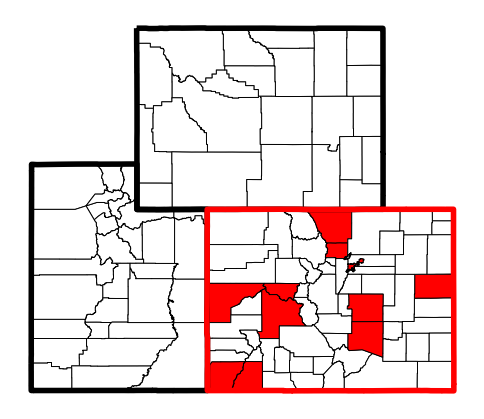

In [28]:
export_file = True
filename = 'map_states_policies'
append = '_CO_UT_WY'

figsize = [6,6]
fig, ax = plt.subplots(1, 1, figsize=figsize)

color0 = 'white'
color1 = 'red'

cmap = colors.ListedColormap([color0, color1])
bounds = [-0.5, 0.5, 1.5]  # Specify the boundaries for the colorbar ticks
norm = colors.BoundaryNorm(bounds, cmap.N)

ax.set_axis_off()

states_around_CO = ['Colorado', 'Utah', 'Wyoming']
n_states = len(states_around_CO)
policy_states = np.array([1,0,0])
pol_states_colors = ['black','red']


gen = np.random.default_rng(232323)
number_counties = [ np.sum(gdf_counties_simple['STATE_NAME'] == state) for state in states_around_CO ]
percentageR_counties = np.array([0.2, 0, 0])
#policy_counties = [ gen.binomial(1, percentageR_counties[nn], size=number_counties[nn]) for nn in range(n_states) ]
policy_counties = [ np.zeros(number_counties[nn]) for nn in range(n_states) ]

# Set Boulder to red
gdf_colorado = gdf_counties_simple[ gdf_counties_simple['STATE_NAME'] == 'Colorado' ]
red_CO_counties = ['Boulder','Denver','Pueblo','Gunnison','El Paso','Pitkin','Mesa',
                   'Larimer','Montezuma','La Plata','Kit Carson']
red_index =  np.where( (gdf_colorado['NAME'].isin(red_CO_counties)).to_numpy() )
policy_counties[0][red_index] = 1


gdf_counties_COUTWY = gdf_counties_simple[ gdf_counties_simple['STATE_NAME'].isin(states_around_CO) ]
gdf_counties_COUTWY.plot(np.concatenate(policy_counties), ax=ax, cmap=cmap, edgecolor='k', linewidth=0.7)

gdf_states_COUTWY = gdf_states_simple[ gdf_states_simple['NAME'].isin(states_around_CO) ]

black_states = policy_states==0
red_states = policy_states==1
black_pol_states = policy_states[black_states]
red_pol_states = policy_states[red_states]

gdf_states_COUTWY[black_states].plot(black_pol_states, ax=ax, cmap=cmap, facecolor='none',
                       edgecolor=[pol_states_colors[val] for val in black_pol_states], linewidth=4)
gdf_states_COUTWY[red_states].plot(red_pol_states, ax=ax, cmap=cmap, facecolor='none',
                       edgecolor=[pol_states_colors[val] for val in red_pol_states], linewidth=4)

if export_file:
    plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

plt.show()

## Plot 2: Group of counties

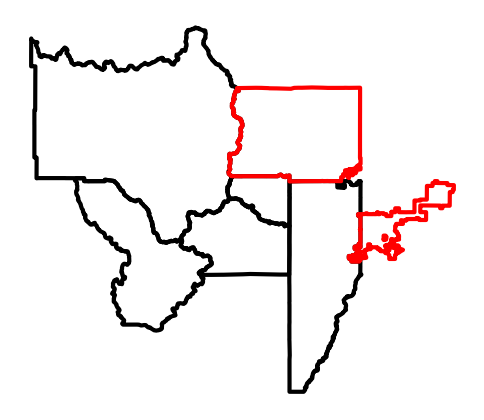

In [29]:
export_file = True
filename = 'map_counties_policies'
append = '_Boulder_Denver_surroundings'

figsize = [6,6]
fig, ax = plt.subplots(1, 1, figsize=figsize)

color0 = 'white'
color1 = 'red'

cmap = colors.ListedColormap([color0, color1])
bounds = [-0.5, 0.5, 1.5]  # Specify the boundaries for the colorbar ticks
norm = colors.BoundaryNorm(bounds, cmap.N)

counties_around_Boulder = ['Boulder', 'Grand', 'Gilpin', 'Jefferson', 'Denver', 'Clear Creek', 'Summit']
n_counties = len(counties_around_Boulder)

ax.set_axis_off()

gdf_colorado = gdf_counties_simple[ gdf_counties_simple['STATE_NAME'] == 'Colorado' ]
gdf_counties_around_Boulder = gdf_colorado[gdf_colorado['NAME'].isin(counties_around_Boulder)]


policy_counties = np.zeros(len(gdf_counties_around_Boulder))
red_index = np.where( (gdf_counties_around_Boulder['NAME'].isin(['Boulder','Denver']) ).to_numpy() )
policy_counties[red_index] = 1

red_counties = policy_counties==1
black_counties = policy_counties==0
red_pol_counties = policy_counties[red_counties]
black_pol_counties = policy_counties[black_counties]

gdf_counties_around_Boulder[black_counties].plot(black_pol_counties, ax=ax, cmap=cmap, facecolor='none',
                       edgecolor='black', linewidth=3)
gdf_counties_around_Boulder[red_counties].plot(red_pol_counties, ax=ax, cmap=cmap, facecolor='none',
                       edgecolor='red', linewidth=3)

if export_file:
    plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

plt.show()

#policy_states = np.array([1,0,0])
#pol_states_colors = ['black','red']


## Plot 3: Countries

World countries boundary data from: Natural Earth,
https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/

Mexico states data from: OCHA,
https://data.humdata.org/dataset/cod-ab-mex?

Canada states data from: Statistics Canada,
https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-eng.cfm?Year=21

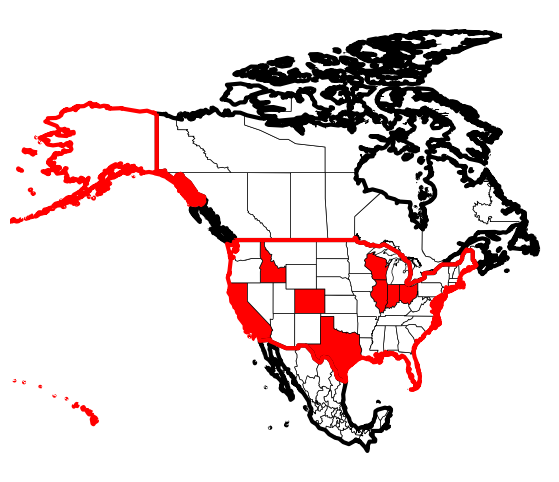

In [30]:
export_file = True
filename = 'map_countries_policies'
append = '_US_MX_CA'

figsize = [8,6]
fig, ax = plt.subplots(1, 1, figsize=figsize)

color0 = 'white'
color1 = 'red'

cmap = colors.ListedColormap([color0, color1])
bounds = [-0.5, 0.5, 1.5]  # Specify the boundaries for the colorbar ticks
norm = colors.BoundaryNorm(bounds, cmap.N)

ax.set_axis_off()
ax.set_xlim(left=-175,right=-50)

n_countries = 3
policy_countries = np.array([1,0,0])
pol_countries_colors = ['black','red']

policy_states = [ np.zeros(len(gdf_states_simple_lessacc)), np.zeros(len(gdf_mexico_states_lessacc)), np.zeros(len(gdf_canada_states_lessacc)) ]

# Set US to red
red_US_states = ['Colorado','California', 'Texas', 'Idaho', 'Wisconsin', 'Illinois', 'Indiana', 'Ohio']
red_index =  np.where( (gdf_states_simple['NAME'].isin(red_US_states)).to_numpy() )
policy_states[0][red_index] = 1

# Plot states
gdf_states_simple_lessacc.plot(policy_states[0], ax=ax, cmap=cmap, edgecolor='k', linewidth=0.5)
gdf_mexico_states_lessacc.plot(policy_states[1], ax=ax, cmap=cmap, edgecolor='k', linewidth=0.5)
gdf_canada_states_lessacc.plot(policy_states[2], ax=ax, cmap=cmap, edgecolor='k', linewidth=0.5)

# Plot countries
select_usa = (gdf_world['SOVEREIGNT']=='United States of America') & (gdf_world['TYPE']=='Country')
select_mexico = gdf_world['SOVEREIGNT']=='Mexico'
select_canada = gdf_world['SOVEREIGNT']=='Canada'

gdf_world_lessacc[select_mexico].plot( ax=ax, cmap=cmap, facecolor='none', edgecolor=pol_countries_colors[0], linewidth=3 )
gdf_world_lessacc[select_canada].plot( ax=ax, cmap=cmap, facecolor='none', edgecolor=pol_countries_colors[0], linewidth=3 )
gdf_world_lessacc[select_usa].plot( ax=ax, cmap=cmap, facecolor='none', edgecolor=pol_countries_colors[1], linewidth=3 )

if export_file:
    plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

plt.show()

## Plot 4: World

Data source on world continents: ArcGIS Hub,
https://hub.arcgis.com/datasets/esri::world-continents/about

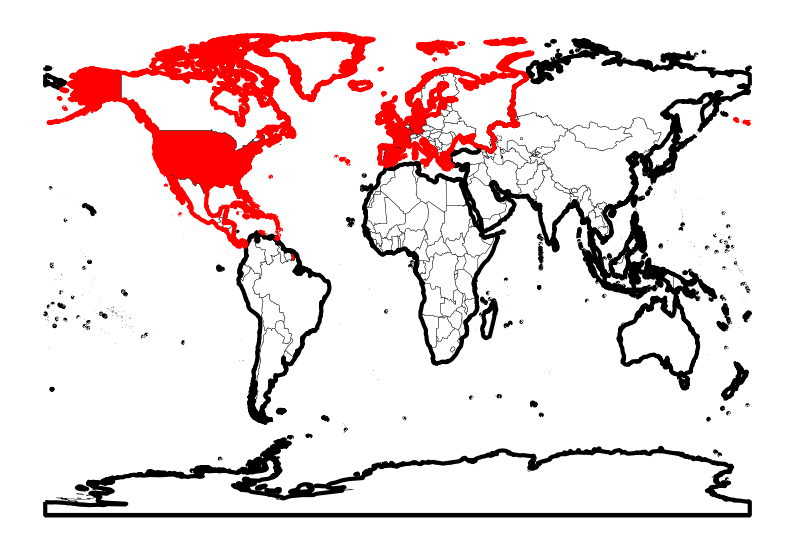

In [31]:
export_file = True
filename = 'map_world_policies'
append = ''

figsize = [10,7]
fig, ax = plt.subplots(1, 1, figsize=figsize)

color0 = 'white'
color1 = 'red'

cmap = colors.ListedColormap([color0, color1])
bounds = [-0.5, 0.5, 1.5]  # Specify the boundaries for the colorbar ticks
norm = colors.BoundaryNorm(bounds, cmap.N)

ax.set_axis_off()
#ax.set_xlim(left=-175,right=-50)

n_continents = len(gdf_world_continents)
policy_continents = np.array([0,0,0,1,0,0,0,1])
pol_continents_colors = ['black','red']

# Set countries to red
policy_countries = np.zeros(len(gdf_world))
red_countries = ['United States of America','Spain', 'Germany', 'France']
red_index =  np.where( (gdf_world['SOVEREIGNT'].isin(red_countries)).to_numpy() )
policy_countries[red_index] = 1

# Plot countries
gdf_world_lessacc.plot(policy_countries, ax=ax, cmap=cmap, edgecolor='k', linewidth=0.3)

# Plot continents
select_black = (policy_continents==0)
select_red = (policy_continents==1)

gdf_world_continents_lessacc[select_black].plot(policy_continents[select_black], ax=ax, cmap=cmap,
                                        facecolor='none', edgecolor=pol_countries_colors[0], linewidth=3 )
gdf_world_continents_lessacc[select_red].plot(policy_continents[select_red], ax=ax, cmap=cmap,
                                        facecolor='none', edgecolor=pol_countries_colors[1], linewidth=3 )

if export_file:
    plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

plt.show()